In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import sys
sys.path.append('../')

In [4]:
from solution.dicom_utils import Patient
from solution.plots import save_images, show_img_msk_fromarray
from solution.dataset import HeartDataset2D
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from pathlib import Path
import pandas as pd
import numpy as np
import cv2

### 1) Initialize patients 

We will initialize Patient objects by using `Patient` class from `dicom_utils` module.

In [6]:
# get path objects
data = list(Path('../final_data/').iterdir())

In [7]:
# read link.csv
links = pd.read_csv(data[-1])
# rename dataframe columns for explicity
links = links.rename(columns={'patient_id':'dicoms', 'original_id':'contourfiles'})
# create link pairs of dicom_id anf contourfiles_id
link_pairs = list(zip(links['dicoms'], links['contourfiles']))

In [8]:
# initialize Patient objects for each link
patients = []
for dicom_id, contour_id in link_pairs:
    patient = Patient(dicom_id=dicom_id,
                      contour_id=contour_id,
                      dicoms_path=data[0],
                      contourfiles_path=data[2])
    patients.append(patient)

### 2) Parse o-contours

For the first part of this challenge we are parsing o-contours for each patient. Here I didn't modify anyhing from the first pipeline since Patient objects store array information across slices for raw images, i-contours and o-contours together.

In [9]:
for patient in patients:
    patient.create_numpy_arrays(False)

In [10]:
# example
patients[0].all_numpy_dict

{1: {'dicom_array': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=int16),
  'i_contour_array': None,
  'o_contour_array': None},
 2: {'dicom_array': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=int16),
  'i_contour_array': None,
  'o_contour_array': None},
 3: {'dicom_array': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=int16),
  'i_contour_array': None,
  'o_contour_array': None},
 4: {'dicom_array': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 

### 3) Heuristic LV Segmentation 

For segmentation we are not allowed to use any ML technique including clustering. In development notebook of part 2 I've tried out several approaches including **simple fixed thresholding**, **OTSU thresholding**, **edge-based segmentation**, **watershed algorithm** and **region growing**. 

Upon these methods **OTSU thresholding** turned out to be the simplest and most effective approach compared to others. In summary edge-based didn't quite work for me, watershed seems to do a good job for overlapping object separation (such as in Data Science Bowl 2018) and region growing is a slow (not vectorized) and manual algorithm which again requires a threshold value (epsilon : difference of intensities between two neighboring pixels).

Apart from these methods I was thinking of applying **k-means** (kind of similar to region growing but with L2 distance) but since we were bounded by non-ML techniques I didn't tried that. But I believe it might be an effective solution for this problem with some post-processing, for k = 2 after ROI extraction.

In [24]:
from solution.heuristics import extract_all_mask_slices
from solution.heuristics import extract_patient_arrays
from solution.heuristics import i_contour_from_o_contour
from solution.metrics import dice_score
from solution.plots import show_all_masks

For i_contour segmentation from o_contour we will use `i_contour_from_o_contour`, a function which takes the raw image and o_contour mask to generate the i_contour. User can specify either a fixed threshold or set argument to `auto` for **OTSU thresholding**. 

This function generates **i_contour proposol** in three steps:

- Generate first proposal by given threshold (either fixed or OTSU)
- Apply opencv closing to fill holes inside 
- Apply opencv opening to remove noise besides the proposal itself

For both closing and opening user can define different kernel types: rect, ellipse and cross as well as different kernel sizes.

**In my experiments I've seen closing after opening to be working good combined between OTSU threshold, kernel_type = cv2.MORPH_RECT and kernel_size = 3.**

For evaluation I've selected `dice_score` as my metric since it's suitable for segmentation tasks. i-contours are only used at evaluation during this challenge. Below I am demonstrating a case where thresholding is not enough to get good results.

In [16]:
# extract slice indexes that has all masks
all_mask_slices = extract_all_mask_slices(patients[0])

In [18]:
# get arrays given the slice index
idx = 0
dicom_array, i_contour_array, o_contour_array =\
                    extract_patient_arrays(patients[0], all_mask_slices[idx])
# generate proposal
proposal = i_contour_from_o_contour(dicom_array,
                                    o_contour_array,
                                    "auto")

	  Raw				 Original  			 Proposal


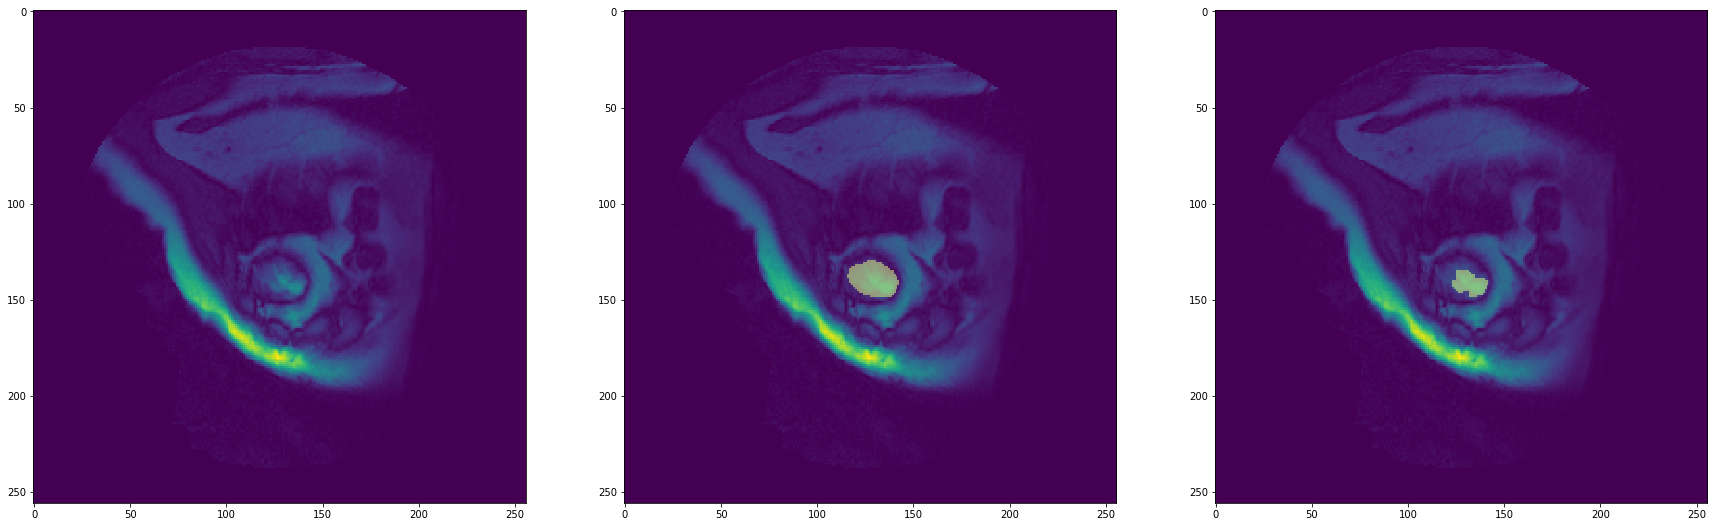

In [41]:
# plot proposal
print("\t  Raw\t\t\t\t Original  \t\t\t Proposal")
show_all_masks(dicom_array, i_contour_array, proposal)

In [42]:
# calc dice score
dice_score(i_contour_array, proposal)

0.6404293381037567

In conclusion, we've seen that thresholding are in general working well for this particular case but results are still not satisfactory since for this task human level accuracy can be obtained. Apart from ML based approaches eventhough I couldn't manage to get it work prety well I still believe edge based methods should work. The idea is to detect the edges from the heart muscle which is obviously seen just by looking at the images. A neural net based approach would be even better since it will not require a lot of manual post-processing (like edge-based), will capture intensities as well as pixel intensities in it's convolutional layers. 

**Note:** A report with plots and metrics is available in pdf format in the repo.